In [1]:
# Class of k-Nearest Neigbor Classifier


class kNN():
    def __init__(self, k = 3, exp = 2):
    # constructor for kNN classifier 
    # k is the number of neighbor for local class estimation
    # exp is the exponent for the Minkowski distance
        self.k = k
        self.exp = exp
      
    def fit(self, X_train, Y_train):
    # training k-NN method
    # X_train is the training data given with input attributes. n-th row correponds to n-th instance.
    # Y_train is the output data (output vector): n-th element of Y_train is the output value for n-th instance in X_train.
        self.X_train = X_train
        self.Y_train = Y_train  
         
    def normalize(self, X_test):
        minn = self.X_train.min()
        maxx = self.X_train.max()
        
        self.X_train = (self.X_train - minn)/(maxx - minn)
        X_test = (X_test - minn)/(maxx - minn)
        
        return self.X_train, X_test
            
    def getDiscreteClassification(self, X_test):
    # predict-class k-NN method
    # X_test is the test data given with input attributes. Rows correpond to instances
    # Method outputs prediction vector Y_pred_test:  n-th element of Y_pred_test is the prediction for n-th instance in X_test
    
        Y_pred_test = [] #prediction vector Y_pred_test for all the test instances in X_test is initialized to empty list []

   
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
                 
            # the first element of the index predictions.index contains the class with the highest count; i.e. the prediction y_pred_test.
            y_pred_test = predictions.index[0]

            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)
        
        return Y_pred_test

    
    def Minkowski_distance(self, x1, x2):
    # computes the Minkowski distance of x1 and x2 for two labeled instances (x1,y1) and (x2,y2)
    
        # Set initial distance to 0
        distance = 0
    
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i])**self.exp
        
        distance = distance**(1/self.exp)
    
        return distance
    
    def getClassProbs(self, X_test):
    # gives probabilities for each class
    # X_test is the test data given with input attributes. Rows correpond to instances
    # Method outputs probabilities dataframe Y_prob_test: colums represent classes, values of n-th row are the probabilities
    # for that n-th instance and the corresponding class
    
        classes_data = self.Y_train.unique()
        Y_prob_test = pd.DataFrame(columns=classes_data)
   
    ## The part below is taken from getDiscreteClassification method. For all comments, check there ##
    
        for i in range(len(X_test)):  
            test_instance = X_test.iloc[i]
            
            distances = [] 
          
            for j in range(len(self.X_train)):  
                train_instance = self.X_train.iloc[j] 
                distance = self.Minkowski_distance(test_instance, train_instance)
                distances.append(distance)
        
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            predictions = self.Y_train[df_knn.index].value_counts()
            
    ## End of the reused code ##
    
            class_and_prob = {} # a new dictionary for n-th X_test instance that has classes as keys and probabilities as
                                # corresponding values
            
            for c in classes_data:
                class_and_prob[c] = 0
                if c in predictions.index:
                    class_and_prob[c] = predictions[c]/predictions.sum()
                 
            # add the probability y_prob_test to the probability vector Y_prob_test for all the test instances in X_test
            Y_prob_test = Y_prob_test.append(class_and_prob, ignore_index = True)
        
        return Y_prob_test


In [2]:
class ROC():
    def __init__(self, Probs, TrueClass):
    # constructor for ROC 
        self.Probs = Probs
        self.TrueClass = TrueClass
        
    def compute_ROC_coordinates(self):
        
        # unite df before sorting
        p_n_c = self.Probs.merge(self.TrueClass, left_index=True, right_index=True)
        
        # sort
        p_n_c = p_n_c.sort_values(by = ['probs', 'class'], axis = 0, ascending = False)
        
        # reset indexes
        p_n_c = p_n_c.reset_index(drop = True)

        #print(p_n_c)
        
        FP = 0 # false positive
        TP = 0 # true positive 
        
        P = (p_n_c['class'] == 'tested_positive').sum()
        N = (p_n_c['class'] == 'tested_negative').sum()
        
        prev_prob = -1
        prev_class = '' # 1 #
        ROC_coord = pd.DataFrame(columns=['X', 'Y'])

        for i in range(len(p_n_c)):   
            p_n_c_instances = p_n_c.iloc[i]
            
            i_th_prob = p_n_c_instances['probs']
            i_th_class = p_n_c_instances['class']
            
            if(i_th_prob != prev_prob or 
               (i_th_prob == prev_prob and i_th_class == 'tested_negative' and prev_class != 'tested_negative')): # 2 #
                
                # Add point (FP/N, TP/P) to ROC_coordinates; 
                ROC_coord = ROC_coord.append({'X' : round(FP/N, 3), 'Y' : round(TP/P, 3)}, ignore_index = True)
                
                # Update previous probability value
                prev_prob = i_th_prob
                prev_class = i_th_class # 3 #

            if(i_th_class == 'tested_positive'):
                TP+=1
            else:
                FP+=1 
                
        ROC_coord = ROC_coord.append({'X' : 1, 'Y' : 1}, ignore_index = True)  
        
        return ROC_coord
    
    def plot_ROC(self, coord_df):
        
        fig, ax = plt.subplots(figsize=(12,8))
        
        plt.plot(coord_df['X'], coord_df['Y'], 'o-')
        plt.suptitle('ROC curve plotted')
        plt.legend(['ROC curve'])
        plt.xlabel('FPr')
        plt.ylabel('TPr')
        
        for index in range(len(coord_df['X'])):
              ax.text(coord_df['X'][index], coord_df['Y'][index], (coord_df['X'][index], coord_df['Y'][index]), size=12)
        plt.show()
        
    def compute_AUCROC(self, coord_df):
        
        area_under_ROC = 0
        x_prev = 0
        
        for i in range(len(coord_df['X'])):   
            x_ith = coord_df.iloc[i]['X']
            y_ith = coord_df.iloc[i]['Y']
            
            area_under_ROC += (x_ith-x_prev) * y_ith
            
            x_prev = x_ith
            
        return area_under_ROC

Provide code to test all the methods of class ROC with a probabilistic classifier from sklearn or the kNN classifier from Lab 2. The data set is the diabetes data set.

Answer: check the code block below

One of the main problems when implementing method compute_ROC_coordinates is  to decide how to handle test instances of opposite classes that have the same probability for the positive class. The pseudocode in Appendix A implements a strategy how to handle this problem. Propose another strategy and implement this strategy in method compute_ROC_coordinates. 

Answer: Lines where I change the approach implemented in pseudocode, Appendix A, are marked with #№# and will be explained below.

The approach implemented in Appendix A simply skips the points of the same probability and does not generate coordinates for all of them, it just adds to the number of truely positive and negative instances while iterating through it.

In my implementation, we create a coordianate point if either the probability of previous instance is not equal to the probability of current instance OR if they are equal, but the current true class is negative and the previous is positive. See this condition in line # 2 #. The dataset is sorted by probabilities in non-ascending order and by true class first being positive and then negative.

Line # 1 # creates a variable for previous class value and line # 3 # updates it.

Visually, by using this implementation, we force the ROC curve to be only "stairs" (no sloped lines when connecting points). Thus, the method that counts area under curve can be implemented conveniently.

Calculated coodrinates 
        X      Y
0  0.000  0.000
1  0.000  0.054
2  0.055  0.054
3  0.055  0.216
4  0.291  0.216
5  0.291  0.378
6  0.582  0.378
7  0.582  1.000
8  1.000  1.000


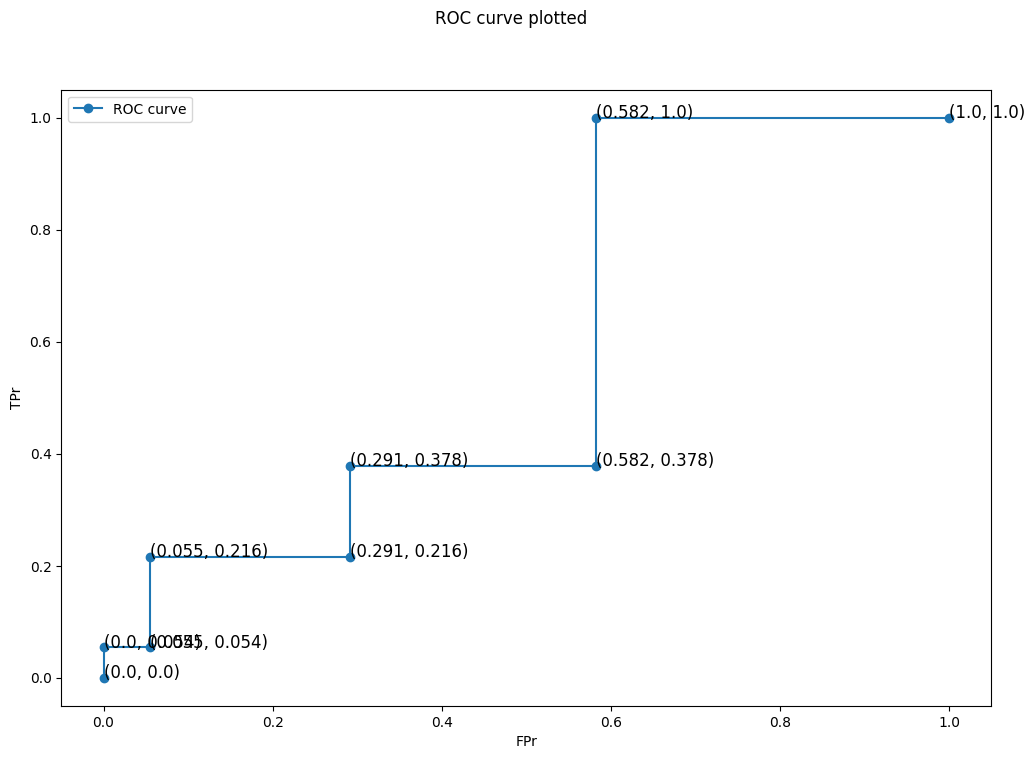

0.581944

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy.random import random
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv('diabetes.csv')
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

test_d = kNN(3)
test_d.fit(X_train, Y_train)
post_probs_d = test_d.getClassProbs(X_test)
#display(post_probs_d)

#pd.set_option('display.max_rows', 100)

# Part A. Create dataframes Probs and TrueClass
Probs = pd.DataFrame({'probs' : post_probs_d['tested_positive']})
TrueClass = pd.DataFrame({'class': Y_test})

# print(Probs['probs'].value_counts())

# Create an object of ROC class
test = ROC(Probs, TrueClass)

# Test part B. Calculate the coordinates
coord = test.compute_ROC_coordinates()
print("Calculated coodrinates \n", coord)

# Test part C. Plot the coordinates of ROC curve
test.plot_ROC(coord)

# Test part D. Compute the area under ROC curve
test.compute_AUCROC(coord)

Below I took an data from Lecture3 example. It's not for grading, it's for me :)

     X      Y
0  0.0  0.000
1  0.0  0.333
2  0.0  0.667
3  0.5  0.667
4  0.5  1.000
5  1.0  1.000


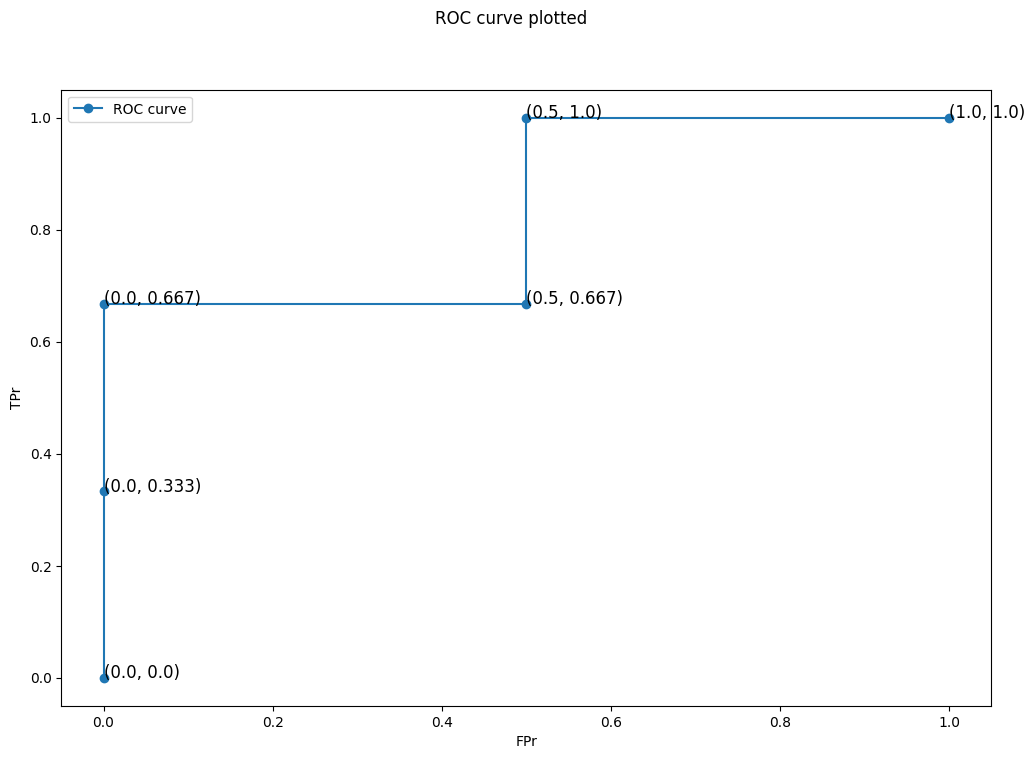

0.8335

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


Probs = pd.DataFrame({'probs': [0.99, 0.98, 0.6, 0.43, 0.7]})
TrueClass = pd.DataFrame({'class': ['tested_positive', 'tested_positive', 'tested_positive', 'tested_negative', 'tested_negative']})

# Create an object of ROC class
test = ROC(Probs, TrueClass)

# Test part B. Calculate the coordinates
coord = test.compute_ROC_coordinates()
print(coord)

# Test part C. Plot the coordinates of ROC curve
test.plot_ROC(coord)

# Test part D. Compute the area under ROC curve
test.compute_AUCROC(coord)